In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!unzip /content/drive/MyDrive/patterns.zip

Archive:  /content/drive/MyDrive/patterns.zip
  inflating: data_pattern/animal/3280.jpg  
  inflating: data_pattern/animal/3281.jpg  
  inflating: data_pattern/animal/3282.jpg  
  inflating: data_pattern/animal/3283.jpg  
  inflating: data_pattern/animal/3284.jpg  
  inflating: data_pattern/animal/3285.jpg  
  inflating: data_pattern/animal/3286.jpg  
  inflating: data_pattern/animal/3287.jpg  
  inflating: data_pattern/animal/3288.jpg  
  inflating: data_pattern/animal/3289.jpg  
  inflating: data_pattern/animal/3290.jpg  
  inflating: data_pattern/animal/3291.jpg  
  inflating: data_pattern/animal/3292.jpg  
  inflating: data_pattern/animal/3293.jpg  
  inflating: data_pattern/animal/3294.jpg  
  inflating: data_pattern/animal/3295.jpg  
  inflating: data_pattern/animal/3296.jpg  
  inflating: data_pattern/animal/3297.jpg  
  inflating: data_pattern/animal/3298.jpg  
  inflating: data_pattern/animal/3299.jpg  
  inflating: data_pattern/animal/3300.jpg  
  inflating: data_pattern/anim

In [4]:
import pandas as pd
import numpy as np
from numpy import random
import os
import matplotlib.pyplot as plt

In [5]:
def read_data(folder):
  labels = os.listdir(folder)
  paths = []
  all_labels = []
  for l in labels:
    path = f"{folder}/{l}"
    folder_data = os.listdir(path)
    for image_path in folder_data:
      all_labels.append(l)
      paths.append(os.path.join(folder, l, image_path))
  return all_labels, paths

In [6]:
all_labels, all_paths = read_data('/content/data_pattern')

In [7]:
df = pd.DataFrame({'path': all_paths, 'label': all_labels})

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train_df, dummy_df = train_test_split(df, train_size=.8, random_state=123, shuffle=True, stratify=df['label'])

valid_df, test_df = train_test_split(dummy_df, train_size=.5, random_state=123, shuffle=True, stratify=dummy_df['label'])

print("Train dataset: ",len (train_df), "Test dataset: ",len(test_df), "Validation dataset: ",len(valid_df))

train_balance = train_df['label'].value_counts()

print('Train dataset value count: \n', train_df['label'].value_counts())

Train dataset:  3384 Test dataset:  423 Validation dataset:  423
Train dataset value count: 
 label
stripes      400
polka dot    398
plain        398
tribal       397
floral       396
squares      351
ikat         284
animal       281
geometry     271
cartoon      208
Name: count, dtype: int64


In [10]:
directory = '/content/data_pattern'

In [11]:
labels = os.listdir(directory)
labels

['ikat',
 'plain',
 'floral',
 'animal',
 'cartoon',
 'tribal',
 'squares',
 'stripes',
 'polka dot',
 'geometry']

In [12]:
labels.sort()

In [13]:
import cv2
import numpy as np

In [14]:
def apply_transform(image):

  # Rotate (random angle between -40 and 40 degrees)
  angle = np.random.uniform(-40, 40)
  rows, cols = image.shape[:2]
  M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
  image = cv2.warpAffine(image, M, (cols, rows))

  # Horizontal Flip
  if np.random.rand() < 0.5:
    image = cv2.flip(image, 1)

  # Vertical Flip
  if np.random.rand() < 0.5:
    image = cv2.flip(image, 0)

  # Random Brightness and Contrast
  alpha = 1.0 + np.random.uniform(-0.2, 0.2)  # Brightness
  beta = 0.0 + np.random.uniform(-0.2, 0.2)   # Contrast
  image = cv2.convertScaleAbs (image, alpha=alpha, beta=beta)

  # Random Gamma Correction
  gamma = np.random.uniform (0.8, 1.2)
  image = np.clip((image / 255.0) ** gamma, 0, 1) * 255.0

  return image

In [15]:
def apply_augmentation(image_path, label):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  augmented_image = apply_transform(image=image)
  return augmented_image, label

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
gen = ImageDataGenerator()

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rescale=1./255)

In [19]:
train_gen = gen.flow_from_dataframe(train_df, x_col='path', y_col='label', target_size=(255,255), seed=123, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=32)

Found 3384 validated image filenames belonging to 10 classes.


In [20]:
valid_gen = gen.flow_from_dataframe(valid_df, x_col='path', y_col='label', target_size=(255,255), seed=123, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=32)

Found 423 validated image filenames belonging to 10 classes.


In [21]:
test_gen = gen.flow_from_dataframe(test_df, x_col='path', y_col='label', target_size=(255,255), seed=123, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=32)

Found 423 validated image filenames belonging to 10 classes.


In [22]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras import regularizers
from keras.models import Model
from keras.optimizers import Adam, Adamax
import tensorflow as tf

In [23]:
model=Sequential()
model.add(Convolution2D(filters=32, kernel_size=3, padding='same', activation="relu",
input_shape=(255, 255, 3)))
model.add(MaxPooling2D(strides=2, pool_size=2, padding= "valid"))
model.add(Convolution2D(filters=32, kernel_size=2, padding='same', activation="relu"))
model.add(MaxPooling2D(strides=2, pool_size=2, padding="valid"))
model.add(Dropout(0.5))
model.add(Convolution2D(filters=32, kernel_size=2, padding='same', activation="relu"))
model.add(MaxPooling2D(strides=2, pool_size=2, padding="valid"))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 255, 255, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 127, 127, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 63, 63, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,936,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,946,826 (15.06 MB)

 Trainable params: 3,946,826 (15.06 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_cnn.h5",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
history_cnn = model.fit(x=train_gen, epochs=40, verbose=1, validation_data=valid_gen, validation_steps=None, shuffle=True, callbacks = [model_checkpoint_callback])

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.1209 - loss: 2.4437
Epoch 1: val_accuracy improved from -inf to 0.16312, saving model to model_cnn.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.1210 - loss: 2.4426 - val_accuracy: 0.1631 - val_loss: 2.2889
Epoch 2/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.1586 - loss: 2.2595
Epoch 2: val_accuracy improved from 0.16312 to 0.18913, saving model to model_cnn.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.1588 - loss: 2.2594 - val_accuracy: 0.1891 - val_loss: 2.2328
Epoch 3/40
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1975 - loss: 2.2072
Epoch 3: val_accuracy improved from 0.18913 to 0.21040, saving model to model_cnn.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.1976 - loss: 2.2068 - val_accuracy: 0.2104 - val_loss: 2.2020
Epoch 4/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2401 - loss: 2.1014
Epoch 4: val_accuracy improved from 0.21040 to 0.26241, saving model to model_cnn.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.2401 - loss: 2.1014 - val_accuracy: 0.2624 - val_loss: 2.1186
Epoch 5/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2664 - loss: 2.0287
Epoch 5: val_accuracy improved from 0.26241 to 0.28842, saving model to model_cnn.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.2664 - loss: 2.0288 - val_accuracy: 0.2884 - val_loss: 2.0942
Epoch 6/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2830 - loss: 1.9686
Epoch 6: val_accuracy improved from 0.28842 to 0.32388, saving model to model_cnn.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.2831 - loss: 1.9687 - val_accuracy: 0.3239 - val_loss: 2.0162
Epoch 7/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3329 - loss: 1.9174
Epoch 7: val_accuracy did not improve from 0.32388
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.3329 - loss: 1.9171 - val_accuracy: 0.3239 - val_loss: 1.9493
Epoch 8/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3533 - loss: 1.8273
Epoch 8: val_accuracy did not improve from 0.32388
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.3533 - loss: 1.8272 - val_accuracy: 0.3239 - val_loss: 1.9911
Epoch 9/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3735 - loss: 1.7421
Epoch 9: val_accuracy did not improve from 0.32388
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.3735 - loss: 1.7420 - val_accuracy: 0.3121 - val_loss: 1.9448
Epoch 10/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4335 - loss: 1.5976
Epoch 10: val_accuracy im

106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.4333 - loss: 1.5981 - val_accuracy: 0.3310 - val_loss: 1.9583
Epoch 11/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4442 - loss: 1.5326
Epoch 11: val_accuracy did not improve from 0.33097
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.4442 - loss: 1.5328 - val_accuracy: 0.2837 - val_loss: 2.0344
Epoch 12/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4827 - loss: 1.4455
Epoch 12: val_accuracy did not improve from 0.33097
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.4826 - loss: 1.4456 - val_accuracy: 0.3073 - val_loss: 2.0173
Epoch 13/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4837 - loss: 1.4054
Epoch 13: val_accuracy did not improve from 0.33097
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.4839 - loss: 1.4052 - val_accuracy: 0.3050 - val_loss: 1.9855
Epoch 14/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5472 - loss: 1.2678
Epoch 14: val_accur

In [28]:
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(255,255,3))
print('Created ResNet50 model')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Created ResNet50 model


In [29]:
for layer in base_model.layers:
  layer.trainable = False

In [30]:
for layer in base_model.layers[173:]:
  layer.trainable = True

In [31]:
x1 = base_model.output

x2 = tf.keras.layers.GlobalAveragePooling2D()(x1)

In [32]:
x3 = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer="he_uniform")(x2)
x4 = tf.keras.layers.Dropout(0.4)(x3)
x5 = tf.keras.layers.Dense(512, activation='relu', kernel_initializer="he_uniform")(x4)

In [33]:
prediction = tf.keras.layers.Dense(10, activation='softmax')(x5)

In [34]:
final_model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction)

In [35]:
final_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
model_checkpoint_callback_rs = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_50.h5",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
history_resnet = final_model.fit(train_gen,
                                 epochs=20, validation_data = valid_gen, callbacks = [model_checkpoint_callback_rs])

Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.1257 - loss: 2.6178
Epoch 1: val_accuracy improved from -inf to 0.20804, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 45s 294ms/step - accuracy: 0.1259 - loss: 2.6156 - val_accuracy: 0.2080 - val_loss: 2.1964
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.1891 - loss: 2.2115
Epoch 2: val_accuracy improved from 0.20804 to 0.22222, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.1892 - loss: 2.2112 - val_accuracy: 0.2222 - val_loss: 2.1135
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2299 - loss: 2.1402
Epoch 3: val_accuracy improved from 0.22222 to 0.24113, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.2298 - loss: 2.1404 - val_accuracy: 0.2411 - val_loss: 2.1160
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.2088 - loss: 2.1338
Epoch 4: val_accuracy did not improve from 0.24113
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy: 0.2089 - loss: 2.1338 - val_accuracy: 0.2317 - val_loss: 2.1130
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2125 - loss: 2.1294
Epoch 5: val_accuracy improved from 0.24113 to 0.24350, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.2127 - loss: 2.1291 - val_accuracy: 0.2435 - val_loss: 2.0682
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2497 - loss: 2.0869
Epoch 6: val_accuracy improved from 0.24350 to 0.27660, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.2496 - loss: 2.0869 - val_accuracy: 0.2766 - val_loss: 2.0402
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2652 - loss: 2.0777
Epoch 7: val_accuracy improved from 0.27660 to 0.30024, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.2651 - loss: 2.0777 - val_accuracy: 0.3002 - val_loss: 2.0294
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2384 - loss: 2.0823
Epoch 8: val_accuracy improved from 0.30024 to 0.30260, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.2386 - loss: 2.0822 - val_accuracy: 0.3026 - val_loss: 2.0276
Epoch 9/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2533 - loss: 2.0807
Epoch 9: val_accuracy did not improve from 0.30260
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.2533 - loss: 2.0807 - val_accuracy: 0.2719 - val_loss: 2.0341
Epoch 10/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2637 - loss: 2.0386
Epoch 10: val_accuracy did not improve from 0.30260
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - accuracy: 0.2637 - loss: 2.0387 - val_accuracy: 0.2931 - val_loss: 2.0167
Epoch 11/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2647 - loss: 2.0465
Epoch 11: val_accuracy improved from 0.30260 to 0.31206, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.2646 - loss: 2.0465 - val_accuracy: 0.3121 - val_loss: 1.9942
Epoch 12/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2733 - loss: 2.0241
Epoch 12: val_accuracy did not improve from 0.31206
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - accuracy: 0.2733 - loss: 2.0243 - val_accuracy: 0.3050 - val_loss: 1.9991
Epoch 13/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2616 - loss: 2.0368
Epoch 13: val_accuracy did not improve from 0.31206
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - accuracy: 0.2617 - loss: 2.0368 - val_accuracy: 0.2931 - val_loss: 2.0031
Epoch 14/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2668 - loss: 2.0479
Epoch 14: val_accuracy did not improve from 0.31206
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.2668 - loss: 2.0479 - val_accuracy: 0.2813 - val_loss: 2.0263
Epoch 15/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2638 - loss: 2.0370
Epoch 15

106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.2803 - loss: 2.0078 - val_accuracy: 0.3286 - val_loss: 1.9638
Epoch 19/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2852 - loss: 1.9850
Epoch 19: val_accuracy did not improve from 0.32861
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.2852 - loss: 1.9852 - val_accuracy: 0.2884 - val_loss: 2.0079
Epoch 20/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2756 - loss: 2.0064
Epoch 20: val_accuracy did not improve from 0.32861
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.2756 - loss: 2.0063 - val_accuracy: 0.2955 - val_loss: 1.9934


In [39]:
import matplotlib.pyplot as plt

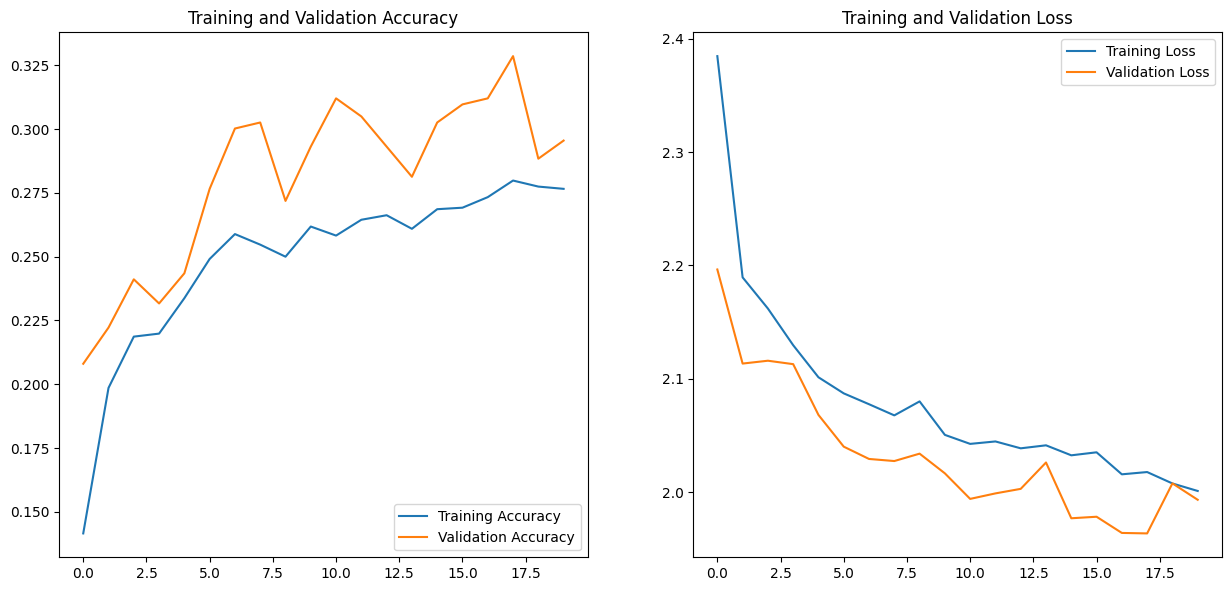

In [44]:
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend (loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend (loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
def predictor(model, test_gen):
  classes = list(test_gen.class_indices.keys())
  class_count = len(classes)
  preds = model.predict(test_gen, verbose=1)
  errors = 0
  pred_indices = []
  test_count = len(preds)

  for i, p in enumerate (preds):
    pred_index = np.argmax(p)
    pred_indices.append(pred_index)
    true_index = test_gen.labels[i]
    if pred_index != true_index:
      errors +=1

  accuracy = (test_count-errors)*100/test_count
  ytrue = np.array(test_gen.labels, dtype='int')
  ypred = np.array(pred_indices, dtype='int')
  msg = f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f}'
  print(msg)
  cm = confusion_matrix(ytrue, ypred)

  # plot the confusion matrix
  plt.figure(figsize=(20, 20))
  sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
  plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
  plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()
  clr = classification_report(ytrue, ypred, target_names=classes, digits=4) # create classification report
  print("Classification Report:\n--------\n", clr)
  return

In [46]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [47]:
def get_model_prediction(image_path):
  img = load_img(image_path, target_size=(255,255))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  predictions = model.predict(x, verbose=0)
  return labels[predictions.argmax()]

In [48]:
pred = []
for file in test_df['path'].values:
  pred.append(get_model_prediction(file))

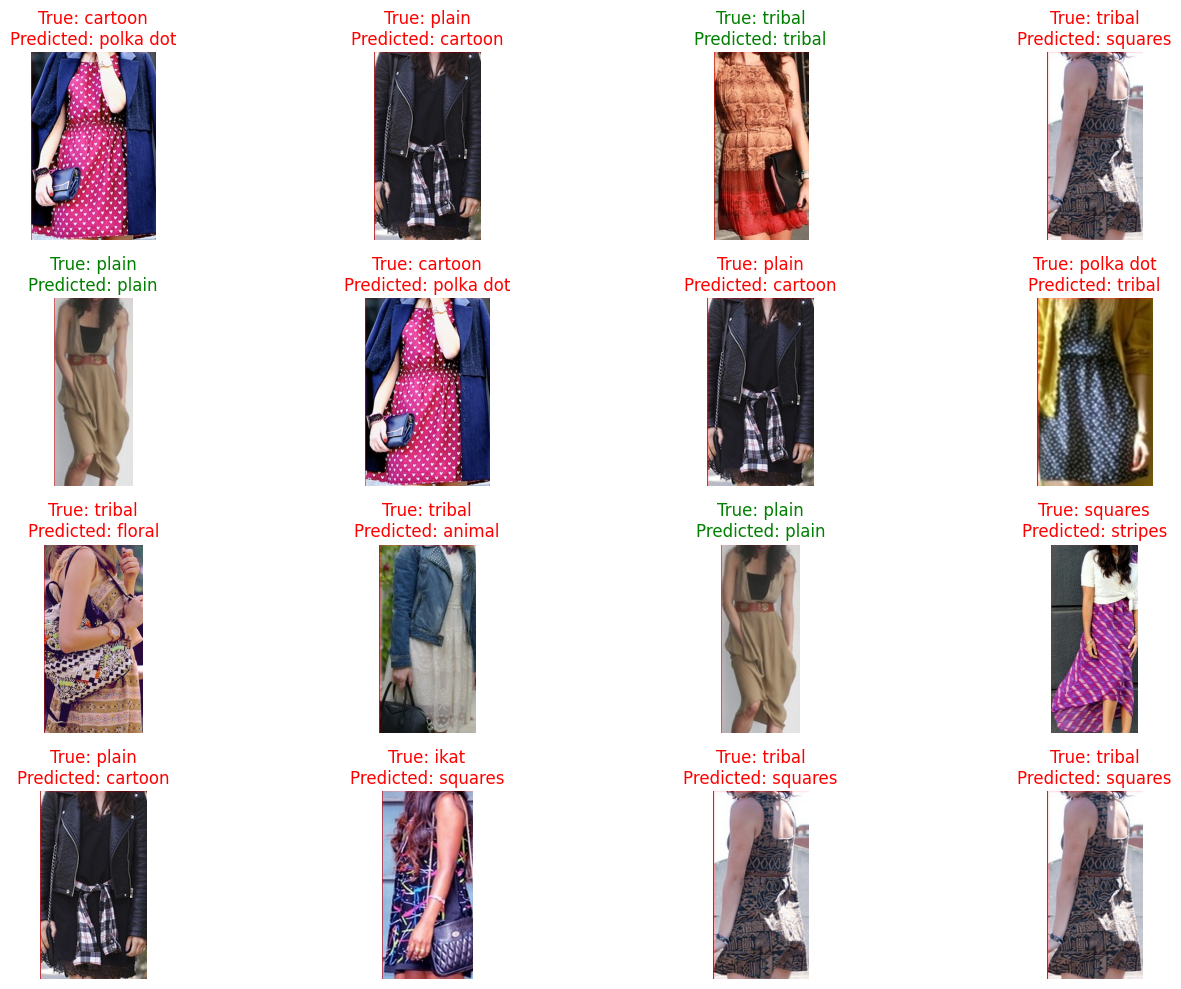

In [49]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))
random_index = np.random.randint(0, len(test_gen), 16)

for i, ax in enumerate(axes.ravel()):
  img_path = test_df['path'].iloc[random_index[i]]

  ax.imshow(load_img(img_path))
  ax.axis('off')

  if test_df['label'].iloc[random_index[i]] == pred[random_index[i]]:
    color="green"
  else:
    color="red"

  ax.set_title(f"True: {test_df['label'].iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

plt.tight_layout()
plt.show()